## 1. Introducción

In [20]:
#Lectura de Datos

library(dataseries)
library(forecast)
library(lmtest)
library(car)
library(TSA)
library(FitAR)

Loading required package: lattice
Loading required package: ltsa
Loading required package: bestglm

Attaching package: ‘FitAR’

The following object is masked from ‘package:car’:

    Boot

The following object is masked from ‘package:forecast’:

    BoxCox



In [21]:
D <- dataseries::ds("TOU.OVR.D")
x = D$TOU.OVR.D
fechas = D$time
n1=which(fechas=="2005-01-01")
n2=which(fechas=="2017-06-01")
x = D$TOU.OVR.D[n1:n2]
fechas = fechas[n1:n2]
np = length(x)

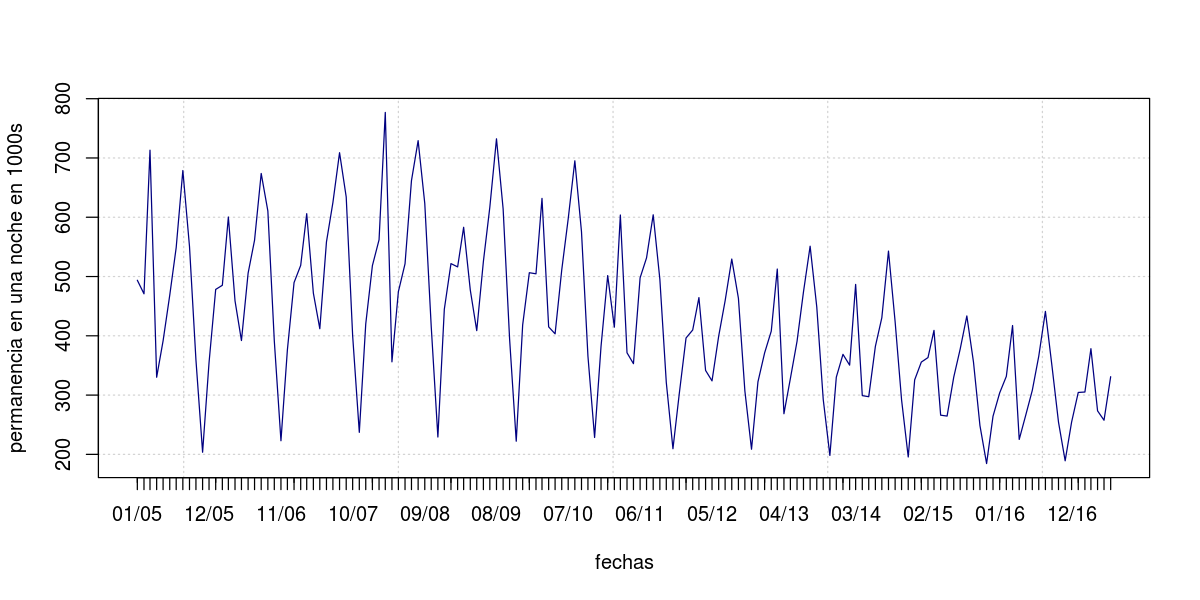

In [2]:
options(repr.plot.width=10, repr.plot.height=5)

ejex.mes = seq(fechas[1],fechas[np], "months")
ejex.año = seq(fechas[1],fechas[np], "years")
plot(fechas,x, xaxt="n", panel.first = grid(),type='l',ylab='permanencia en una noche en 1000s', lwd = 1, col = 'navy')
axis.Date(1, at=ejex.mes, format="%m/%y")
axis.Date(1, at=ejex.año, labels = FALSE, tcl = -0.2)

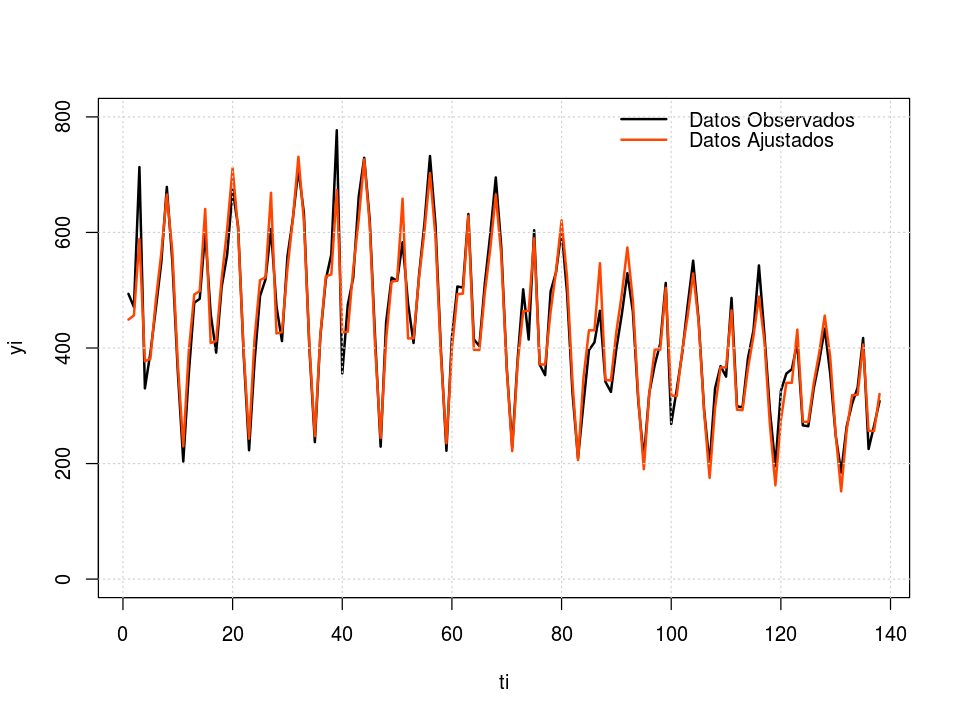

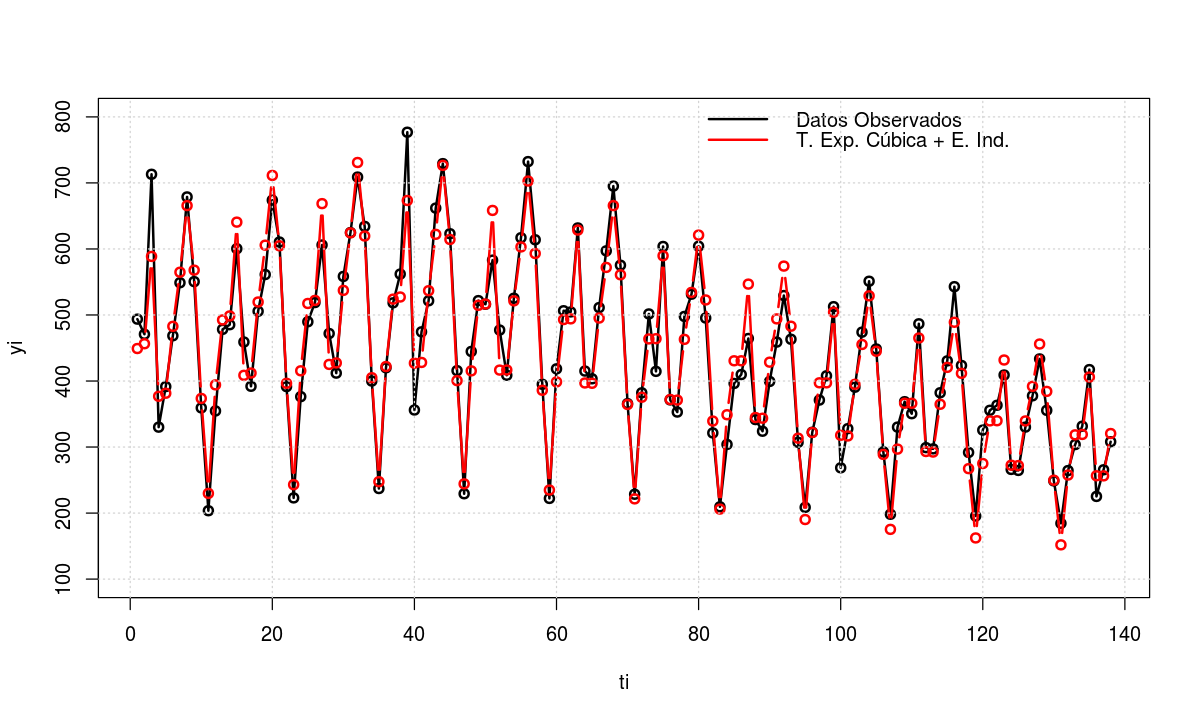

In [3]:
y = ts(x,frequency=12,start=c(2005,1),end=c(2017,6))

#Separacion datos de entrenamiento y de validacion cruzada
#Se separa un año de datos

m = 12
n = length(y)
yi = ts(y[1:(n-m)],frequency=12)
yf = ts(y[(n-m+1):n],frequency=12)

lyi = log(yi) #modelo log-lin

#Tendencia: Lineal + Estacionalidad: Indicadoras

ti = seq(1,length(yi))
ti2 = ti*ti
ti3 = ti2*ti

It = seasonaldummy(yi)

#Tendencia: log cubico + Estacionalidad: Indicadoras
mod8 = lm(lyi ~ ti + +ti2 + ti3 + It)

# El modelo exponencial-cubico-estacional - Indicadoras

T = length(yi)
Xt = cbind(rep(1,T),ti,ti2,ti3,It)
Ds = data.frame(yi,Xt)
theta.0 = mod8$coefficient
mod9 = nls(yi~exp(Xt%*%theta), data=Ds, start= list(theta=theta.0))

yhat9 = fitted(mod9)
r9 <- yi-yhat9
#par(mfrow=c(2,2))
#plot(ti,r9,type='o',ylab='residuo')
#abline(h=0,lty=2)
#plot(density(r9),xlab='x',main= '')
#qqnorm(r9)
#qqline(r9,col=2)

par(mfrow=c(1,1))

options(repr.plot.width=8, repr.plot.height=6)
plot(ti, yi, type = "l", lwd = 2, ylim = c(0,800))
lines(ti, yhat9, col = "orangered1", lwd = 2)
legend( "topright",                              # posicion
        c("Datos Observados","Datos Ajustados"),                 # texto
        lwd = c(2, 2),                          # grosor lineas
        col = c('black','orangered1'),                 # color lineas
        bty = "n")                              # sin caja alrededor de la leyenda
grid()

par(mfrow=c(1,1))

options(repr.plot.width=10, repr.plot.height=6)
plot(ti,yi,type='o', ylim = c(100,800), lwd=2)
lines(ti,yhat9,col = 'red',type='b', lwd =2)

legend("topright", 
    c("Datos Observados","T. Exp. Cúbica + E. Ind."), 
    col = c("black","red"),
    lty=1,
    bty='n', 
    #cex=.75,
    lwd = c(2, 2), )
grid()



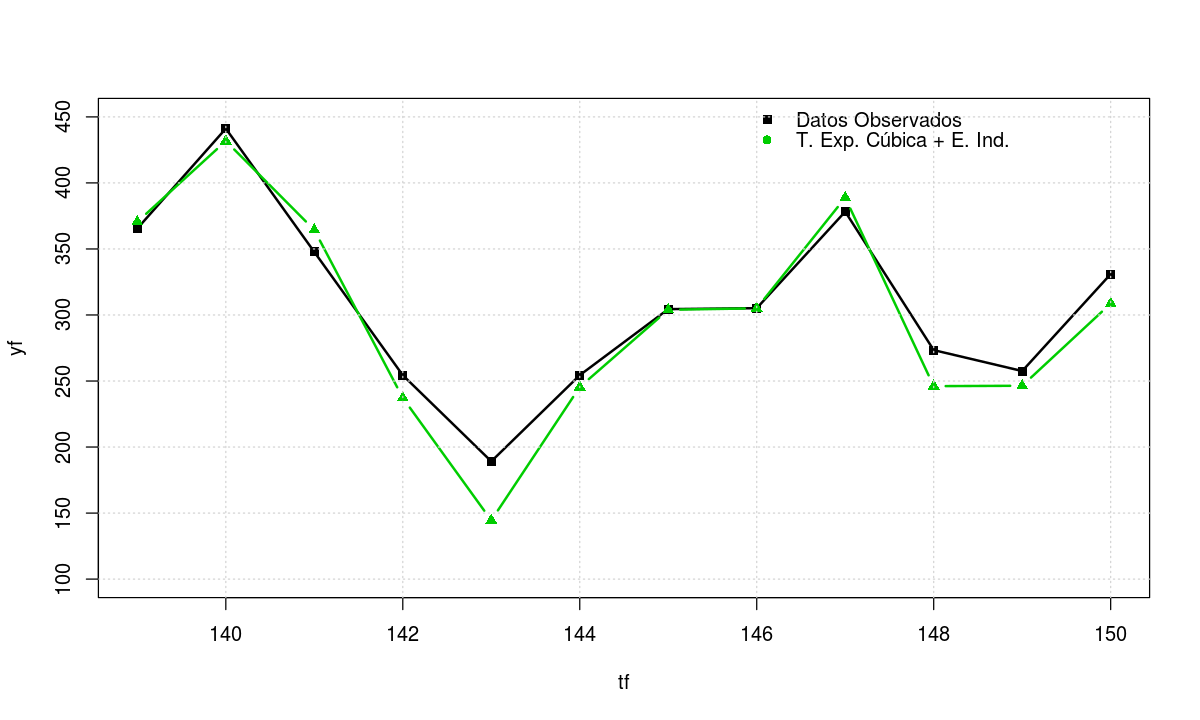

In [4]:
T = length(yi)
Itf = seasonaldummy(yi,m)
tf = seq(T+1,T+m,1)

tf2 = tf*tf
tf3 = tf2*tf
Xtf = cbind(rep(1,m),tf,tf2,tf3,Itf)

pron3 = predict(mod9,data.frame(Xt = I(Xtf)))

par(mfrow=c(1,1))
plot(tf,yf, type = 'o', pch = 15, ylim=c(100,450), lwd=2)
lines(tf,pron3, type = 'b', pch = 17,col='green3', lwd=2 )

legend("topright", c("Datos Observados", "T. Exp. Cúbica + E. Ind."),  bty='n', pch = c(15, 16, 17), 
       col = c("black","green3"))

grid()

Contextualice la serie: definición, frecuencia, perı́odo de los datos, fuente
de los datos (solo si está disponible). Describa el modelo que mejor pronosticó la serie
en el Trabajo No 1. Incluya una gráfica de los pronósticos estructurales versus los datos
observados, para el perı́odo de validación cruzada. Describa el objetivo de su análisis de
acuerdo a los puntos siguientes.

## 2. Pruebas de incorrelación ##

Realice las Pruebas de incorrelación con los residuos
estructurales: Ljung-Box, Durbin-Watson (cuando sea posible), y la gráfica de la fac
y la fac parcial con las bandas de Bartlett. Concluya sobre si los residuos son ruido
blanco o no. De ser posible, identifique un AR(p) ó un MA(q) con estas gráficas.



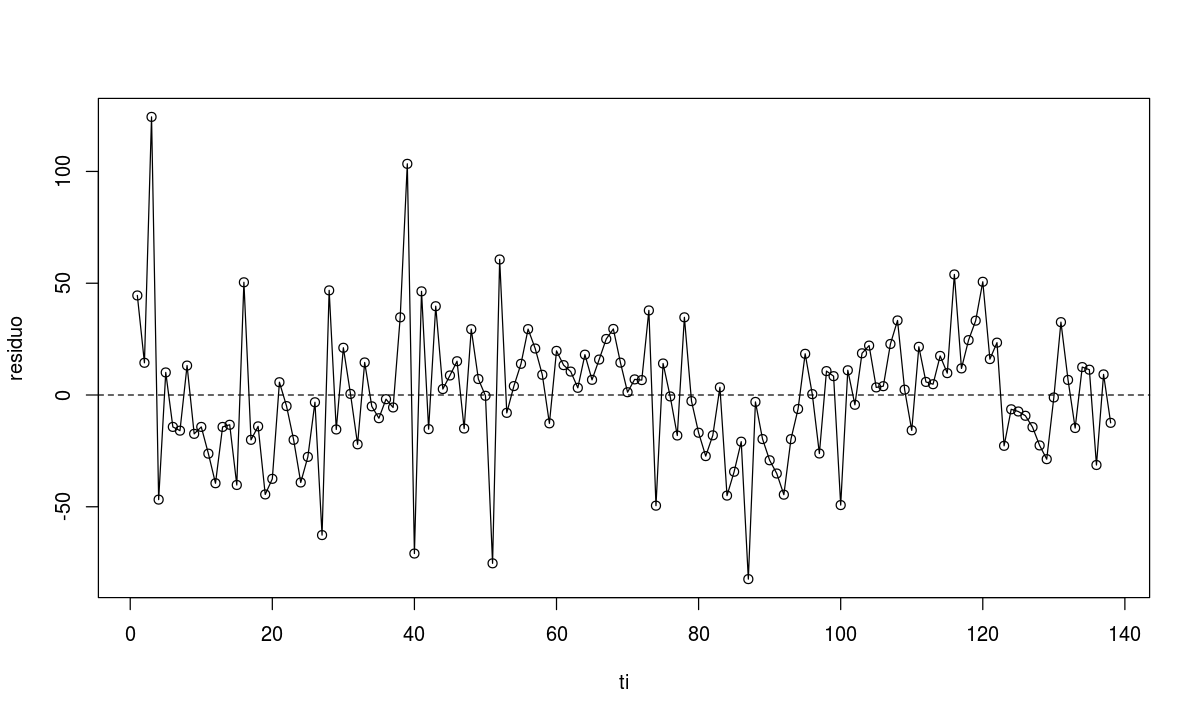

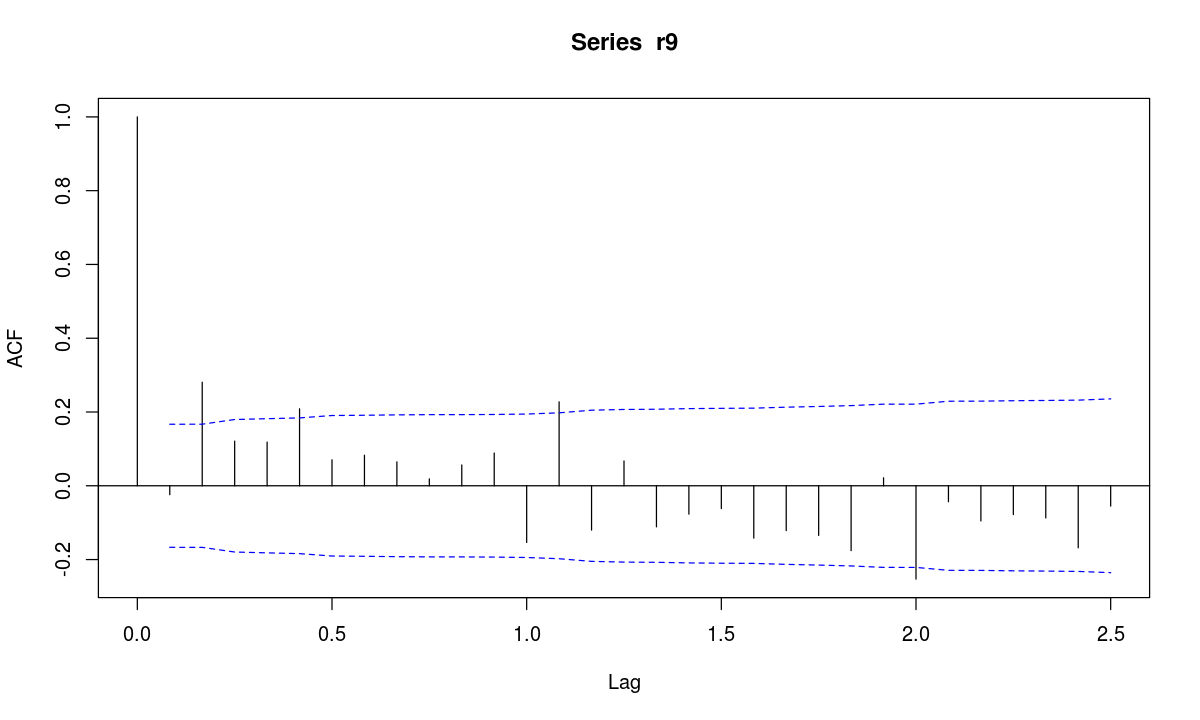

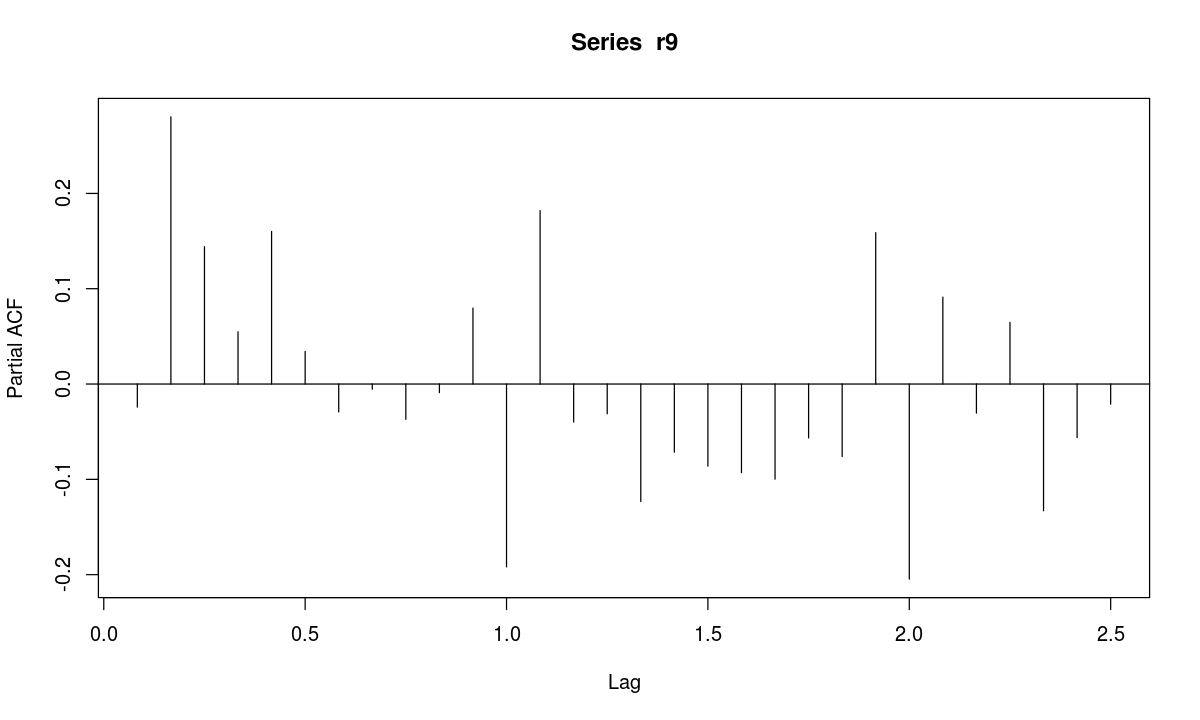

In [5]:
#-------------graficar autocorrelacion (fac)

par(mfrow=c(1,1))
plot(ti,r9,type='o',ylab='residuo')
abline(h=0,lty=2)
acf(r9,30,ci.type="ma")
pacf(r9,30,ci.type='ma')


In [6]:
cat('Pruebas Box-Ljung')
Box.test(r9, lag = 5 , type =  "Ljung-Box")
Box.test(r9, lag = 15 , type =  "Ljung-Box")
Box.test(r9, lag = 25 , type =  "Ljung-Box")

Pruebas Box-Ljung


	Box-Ljung test

data:  r9
X-squared = 21.708, df = 5, p-value = 0.0005948



	Box-Ljung test

data:  r9
X-squared = 40.372, df = 15, p-value = 0.0003984



	Box-Ljung test

data:  r9
X-squared = 68.957, df = 25, p-value = 5.491e-06


In [13]:
# Se define una nueva serie para agregar el ruido del modelo y poder aplicar DW
xt <- rep(0,length(yi))

for (t in 1:length(yi)){
    xt[t] <- r9[t]
}
     
m_dw <- lm(xt ~ ti)

dwtest(m_dw) # de la libreria lmtest

durbinWatsonTest(m_dw,max.lag = 15)


	Durbin-Watson test

data:  m_dw
DW = 2.0336, p-value = 0.5446
alternative hypothesis: true autocorrelation is greater than 0


 lag Autocorrelation D-W Statistic p-value
   1     -0.02645121      2.033631   0.952
   2      0.27874281      1.420686   0.000
   3      0.11643249      1.605692   0.018
   4      0.11450047      1.592067   0.024
   5      0.20484650      1.409328   0.000
   6      0.06643548      1.682556   0.130
   7      0.07913294      1.655257   0.100
   8      0.06130401      1.681354   0.174
   9      0.01538833      1.771043   0.452
  10      0.05284372      1.687167   0.252
  11      0.08517716      1.612608   0.124
  12     -0.15715372      2.083252   0.158
  13      0.22455291      1.317485   0.008
  14     -0.12341638      2.011580   0.270
  15      0.06463627      1.622502   0.260
 Alternative hypothesis: rho[lag] != 0

Comentarios....

- Criterios para aceptacion de la prueba Ljung-Box
- Criterios para determinar  AR o MA a partir de la grafica
- Criterios para aceptacion de la prueba Durbin-Watson

## 3. Identificación ##

a) con armasubsets. Identifique un posible modelo ARMA-SARMA mediante la
función armasubsets() de la librerı́a TSA. Recuerde declarar los residuos con
la función ts(et,frequency=), utilizando la misma frecuencia que para la serie
original Y t . Reporte el modelo.

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“19  linear dependencies found”

Reordering variables and trying again:


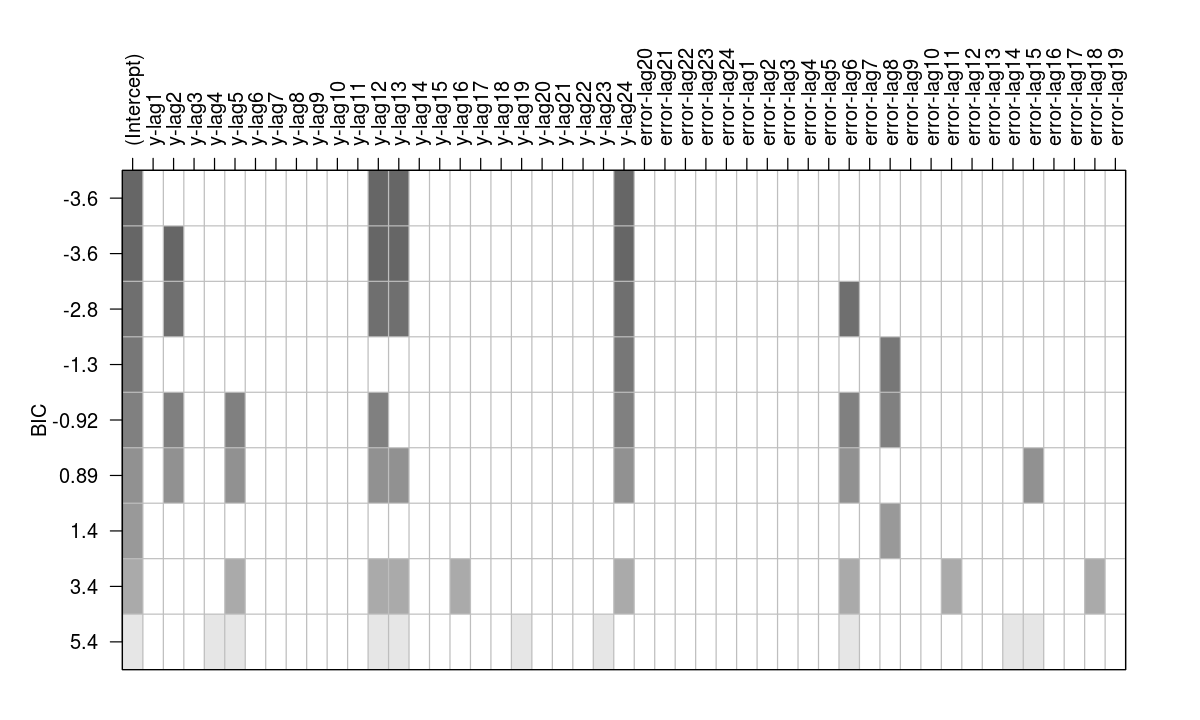

In [18]:
#------------identificador armasubsets

res=armasubsets(y=r9,
nar=24,nma=24,
y.name='y',
ar.method='ols')

par(mfrow=c(1,1))
plot(res)

Comentarios
-  Cual es el valor maximo de AR que se puede parametrizar
-  Cual es el valor maximo de MA que se puede parametrizar

b) con SelectModel. Identifique un posible modelo AR(p) para los residuos mediante la función SelectModel() de la librerı́a FitAR. Reporte el orden p.

In [25]:
posmod = SelectModel(r9, ARModel="AR", Criterion="AIC", lag.max=floor(10*log10(length(r9))), Best=1)
posmod

modres = FitAR(r9,posmod,MeanMLEQ=TRUE)
modres


[1] 5

Warning message in matrix(c(racf, sdRacf), ncol = 2):
“la longitud de los datos [55] no es un submúltiplo o múltiplo del número de filas [28] en la matriz”Warning message in (ra^2)/(n - (1:lag.max)):
“longitud de objeto mayor no es múltiplo de la longitud de uno menor”

AR(5). MLE.  Mean estimated using MLE
length of series = 138 ,  number of parameters = 6
loglikelihood = -458.329 ,  AIC = 928.7 ,  BIC =  946.2

c) con auto.arima. Identifique un posible modelo ARMA-SARMA mediante la
función auto.arima() de la librerı́a forecast. Aplicar las restricciones: stationary=TRUE,
seasonal=TRUE para obtener un modelo estacionario estacional. 
Use el código siguiente. 
Reporte el modelo.

 
auto.arima(y, d=NA, D=NA,max.p=3, max.q=3,max.P=2, max.Q=2,  
max.order=5, start.p=2, start.q=2, start.P=1, start.Q=1,  
stationary=TRUE, seasonal=TRUE,  
ic= "aicc", stepwise=TRUE, trace=FALSE,  
approximation=(length(lPb)>100 | frequency(lPb)>12))  

d ) con autoarmafit. Identifique un posible modelo ARMA-SARMA mediante la
función autoarmafit() de la librerı́a timsac. Reporte el modelo.

## 3. Estimación ##

Debe escoger un modelo entre los candidatos encontrados con los méto-
dos anteriores. Una opción es escoger el de menor AIC. Calcule AIC(modelo), con
modelo el objeto producido por la función arima(), para cada uno de los posibles
modelos. Con el modelo escogido valide los residuos con el panel de gráficas (fac, facp,
qqplot, densidad, periodograma acumulado y la prueba Ljung-Box. En caso de no
obtener ruido blanco ensaye con otro de los modelos encontrados.

## 4. Pronósticos ## 

Calcule pronósticos de los residuos estructurales con el modelo determinado en el punto anterior. Añádalos a los pronósticos estructurales del Trabajo No 1. Reporte el MAPE de estos dos conjuntos de pronósticos y reporte si el modelo
ARMA-SARMA mejora los pronósticos estructurales.

## Conclusiones ## 

Presente conclusiones sobre los resultados.